<a href="https://colab.research.google.com/github/Dianamikolo/Machine-Learning/blob/main/projet_datascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [13]:
# Générer des données simulées pour 2000 échantillons
# np.random.seed(42)
# n_samples = 2000

# data = {
#     'température': np.random.uniform(15, 30, n_samples),  # Température en °C
#     'luminosité': np.random.uniform(100, 800, n_samples),  # Luminosité en lux
#     'présence': np.random.choice([0, 1], n_samples),  # 0 = vide, 1 = occupé
#     'consommation': np.random.uniform(100, 500, n_samples)  # Conso en Wh
# }

# df = pd.DataFrame(data)
# df.to_csv("consommation_energetique.csv", index=False)
# df.head()


,température,luminosité,présence,consommation
0,20.618102,283.193979,1,257.454208
1,29.260715,272.885159,0,289.374264
2,25.979909,734.378206,1,441.818957
3,23.979877,274.682340,0,236.001754
4,17.340280,290.364808,0,447.859874


In [ ]:
from google.colab import files
uploaded = files.upload()  # Télécharge ton fichier ici

df = pd.read_csv("consommation_energetique.csv")
df.head()


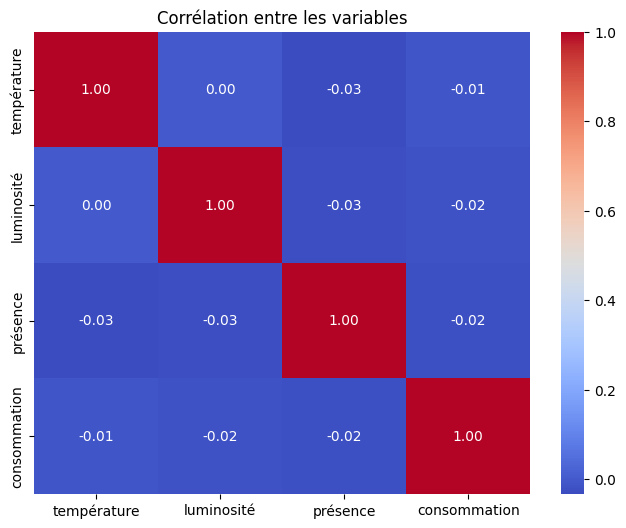

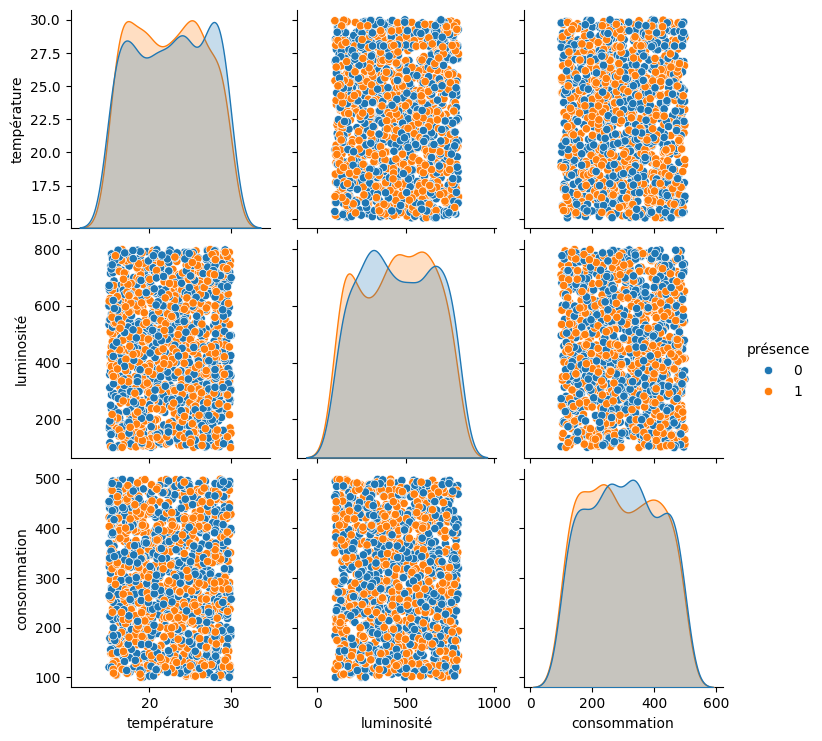

In [3]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre les variables")
plt.show()

sns.pairplot(df, hue="présence")
plt.show()


In [4]:
# Séparation des features (X) et de la cible (y)
X = df[['température', 'luminosité', 'présence']]
y = df['consommation']

# Séparation des données en training (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
# Initialisation et entraînement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions sur les données test
y_pred = model.predict(X_test)


In [6]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"📊 Évaluation du Modèle :")
print(f"MAE  : {mae:.2f} Wh (Erreur absolue moyenne)")
print(f"MSE  : {mse:.2f} Wh² (Erreur quadratique moyenne)")
print(f"RMSE : {rmse:.2f} Wh (Racine de l'erreur quadratique moyenne)")


📊 Évaluation du Modèle :
MAE  : 102.65 Wh (Erreur absolue moyenne)
MSE  : 14941.79 Wh² (Erreur quadratique moyenne)
RMSE : 122.24 Wh (Racine de l'erreur quadratique moyenne)


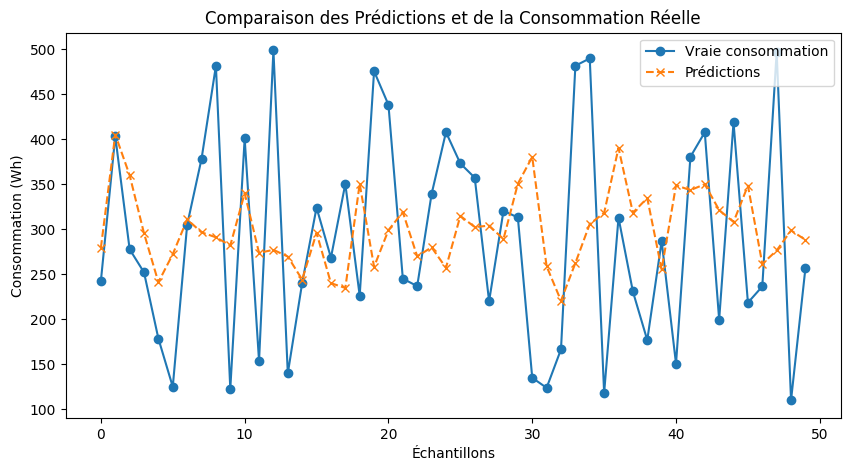

In [7]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:50], label="Vraie consommation", marker="o")
plt.plot(y_pred[:50], label="Prédictions", linestyle="dashed", marker="x")
plt.xlabel("Échantillons")
plt.ylabel("Consommation (Wh)")
plt.title("Comparaison des Prédictions et de la Consommation Réelle")
plt.legend()
plt.show()


## Introduction à la Logique Floue

Exemple de règles floues :

🔹 Si température élevée ET présence détectée → Réduire la climatisation modérément.

🔹 Si luminosité faible ET présence détectée → Augmenter l'éclairage progressivement.

🔹 Si consommation trop élevée → Optimiser l’alimentation en énergie.



In [8]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.8 MB/s eta 0:00:00


In [9]:
# Définition des variables d'entrée
température = ctrl.Antecedent(np.arange(15, 31, 1), 'température')
luminosité = ctrl.Antecedent(np.arange(100, 801, 50), 'luminosité')
présence = ctrl.Antecedent(np.arange(0, 2, 1), 'présence')

# Variable de sortie : consommation énergétique
consommation = ctrl.Consequent(np.arange(100, 501, 50), 'consommation')

# Définition des ensembles flous
température.automf(3)  # ['poor', 'average', 'good'] → ['basse', 'moyenne', 'élevée']
luminosité.automf(3)
présence['absent'] = fuzz.trimf(présence.universe, [0, 0, 1])
présence['présent'] = fuzz.trimf(présence.universe, [0, 1, 1])

consommation['faible'] = fuzz.trimf(consommation.universe, [100, 150, 250])
consommation['moyenne'] = fuzz.trimf(consommation.universe, [200, 300, 400])
consommation['élevée'] = fuzz.trimf(consommation.universe, [350, 450, 500])


In [10]:
rule1 = ctrl.Rule(température['poor'] & présence['présent'], consommation['faible'])
rule2 = ctrl.Rule(température['average'] & présence['présent'], consommation['moyenne'])
rule3 = ctrl.Rule(température['good'] & présence['présent'], consommation['élevée'])
rule4 = ctrl.Rule(luminosité['poor'] & présence['présent'], consommation['moyenne'])
rule5 = ctrl.Rule(luminosité['good'], consommation['faible'])
rule6 = ctrl.Rule(présence['absent'], consommation['faible'])


In [11]:
# Création du système de contrôle
consommation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
consommation_sim = ctrl.ControlSystemSimulation(consommation_ctrl)

# Test du système avec des valeurs réelles
consommation_sim.input['température'] = 28  # °C
consommation_sim.input['luminosité'] = 200  # lux
consommation_sim.input['présence'] = 1  # Présence détectée

# Calcul de la décision
consommation_sim.compute()
print(f"Consommation énergétique optimisée : {consommation_sim.output['consommation']:.2f} Wh")


Consommation énergétique optimisée : 357.11 Wh
